In [1]:
import sys
parentdir = ".."
sys.path.insert(0, parentdir)

import requests
from os import path
from tqdm.notebook import tqdm
import pandas as pd
import time

from metrics.WebResource import WebResource
from metrics.FAIRMetricsFactory import FAIRMetricsFactory
from metrics.AbstractFAIRMetrics import AbstractFAIRMetrics

[WDM] - 

[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 100.0.4896
[WDM] - Get LATEST driver version for 100.0.4896
[WDM] - Driver [/Users/gaignard-a/.wdm/drivers/chromedriver/mac64/100.0.4896.60/chromedriver] found in cache


# Retrieve a Bioschemas RDF dump

In [2]:
dump = "bioschemas-dump.ttl"
if not path.isfile(dump):
    r = requests.get("https://github.com/bio-tools/content/raw/master/datasets/bioschemas-dump.ttl")
    assert r.status_code == 200
    with open(dump, "wb") as f:
        f.write(r.content)

assert path.isfile(dump)

# Load the RDF dump

In [3]:
from rdflib import ConjunctiveGraph, Namespace, URIRef
from rdflib.namespace import RDF, RDFS

schema = Namespace("http://schema.org/")

In [4]:
KG = ConjunctiveGraph()
KG.parse(dump, format="turtle")
print(f"{len(KG)} loaded triples")

483678 loaded triples


In [5]:
index = {}
for s, p, o in KG.triples((None, RDF.type, schema.SoftwareApplication)):
    index[str(s)] = None    
print(print(f"{len(index)} software applications"))

25048 software applications
None


In [6]:
def index_dump():
    for i in tqdm(index.keys()):
        sub_graph = ConjunctiveGraph()
        for s, p, o in KG.triples((URIRef(i), None, None)):
            sub_graph.add((s, p, o))
        index[i]=sub_graph


def get_RDF_sparql(bio_tools_Id):
    q = f"CONSTRUCT {{<{bio_tools_Id}> ?p ?o}} WHERE {{<{bio_tools_Id}> rdf:type schema:SoftwareApplication . <{bio_tools_Id}> ?p ?o .}}"
    res = KG.query(q)
    print(res.serialize(format="turtle"))

def get_RDF(bio_tools_Id):
    sub_graph = ConjunctiveGraph()
    for s, p, o in KG.triples((URIRef(bio_tools_Id), None, None)):
        sub_graph.add((s, p, o))
    print(sub_graph.serialize(format="turtle"))    
    
#get_RDF_sparql("https://bio.tools/bwa")
#get_RDF("https://bio.tools/bwa")

In [7]:
index_dump()

  0%|          | 0/25048 [00:00<?, ?it/s]

In [8]:
import random
#sample_tool = random.choice(index.keys())

random.seed(10)

#samples = random.sample(list(index.items()), 1000)
samples = random.sample(list(index.items()), len(index.items()))

#splitedSize = 1000
#samples_chunks = [samples[x:x+splitedSize] for x in range(0, len(samples), splitedSize)]

In [9]:
#%%capture
from profiles.bioschemas_shape_gen import validate_any_from_KG
from profiles.bioschemas_shape_gen import bs_profiles

soft_min = len(bs_profiles["sc:SoftwareApplication"]["min_props"])
soft_rec = len(bs_profiles["sc:SoftwareApplication"]["rec_props"])

df = pd.DataFrame()
rows =  []

for s in tqdm(samples):
    row =  {}
    row["id"] =  s[0]
    res = validate_any_from_KG(kg=s[1])
    row["Mandatory properties"] = (1 - (len(res[s[0]]["errors"]) / soft_min))  * 100
    row["Recommended properties"] = (1 - (len(res[s[0]]["warnings"])  / soft_rec)) * 100
    rows.append(row)

df = pd.concat([df, pd.DataFrame.from_records(rows)])    
df

  0%|          | 0/25048 [00:00<?, ?it/s]

,id,Mandatory properties,Recommended properties
0,https://bio.tools/ppms,100.0,37.5
1,https://bio.tools/DRAMP,100.0,50.0
2,https://bio.tools/m3drop,100.0,75.0
3,https://bio.tools/mrcip,100.0,50.0
4,https://bio.tools/probe,100.0,50.0
...,...,...,...
25043,https://bio.tools/topmatch,100.0,50.0
25044,https://bio.tools/spatzie,100.0,62.5
25045,https://bio.tools/riboexp,100.0,50.0
25046,https://bio.tools/proq2,100.0,50.0


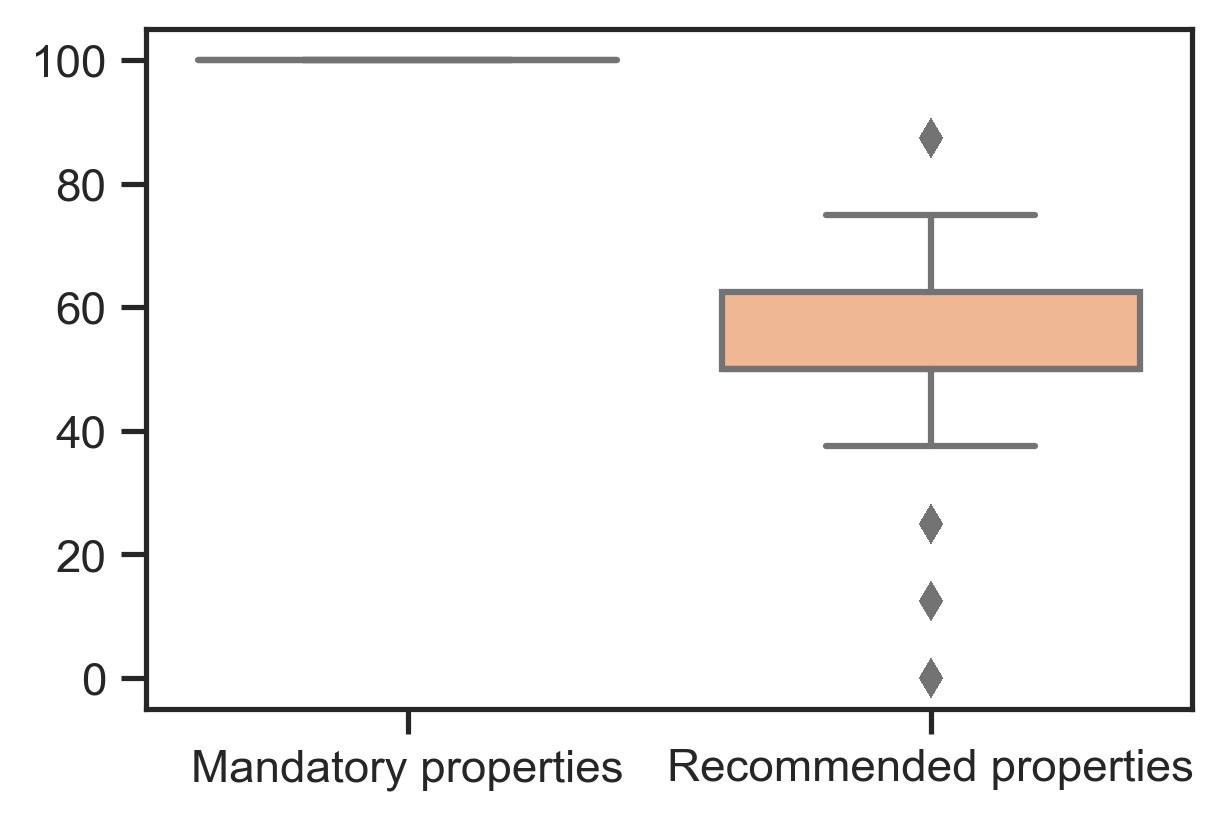

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="ticks", palette="pastel")

plt.rcParams['figure.figsize'] = [4.5, 3]
plt.rcParams['figure.dpi'] = 300 
n = len(samples)
sns.boxplot(data=df)
#plt.suptitle(f"Compliance of {n} bioinformatics softwares with Bioschemas profiles")
plt.savefig('bioschemas-profiles.png')

In [11]:
print(df["Recommended properties"].mean())
print(df["Mandatory properties"].mean())

53.9908375918237
100.0


In [12]:
print(df["Recommended properties"].std())
print(df["Mandatory properties"].std())

12.619903857761363
0.0


In [13]:
df

,id,Mandatory properties,Recommended properties
0,https://bio.tools/ppms,100.0,37.5
1,https://bio.tools/DRAMP,100.0,50.0
2,https://bio.tools/m3drop,100.0,75.0
3,https://bio.tools/mrcip,100.0,50.0
4,https://bio.tools/probe,100.0,50.0
...,...,...,...
25043,https://bio.tools/topmatch,100.0,50.0
25044,https://bio.tools/spatzie,100.0,62.5
25045,https://bio.tools/riboexp,100.0,50.0
25046,https://bio.tools/proq2,100.0,50.0
